In [1]:
import re
import glob
import os
import json
import pandas as pd
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')
import seaborn as sns

In [2]:
runs=1
dispatch_dfs = []
rays_dfs = []

In [3]:
# Process Swift DispatchBenchmark files
for run in range(1, runs+1):
    for file in glob.glob(f'benchmark-results/swift/{run}/Current_run.DispatchBenchmark.*.wallClock.histogram.samples.tsv'):
        base = os.path.basename(file)
        # Example file name:
        # Current_run.DispatchBenchmark.dispatchExistential(classCount:14).wallClock.histogram.samples.tsv
        m = re.search(r'DispatchBenchmark.dispatch([A-Za-z]+)\(classCount:([0-9]+)\)', base)

        df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

        df['Class count'] = int(m.group(2))
        df['Version'] = "Swift " + m.group(1)
        df['Run'] = run

        dispatch_dfs.append(df)

In [4]:
# Process Swift RaysBenchmark files
for run in range(1, runs+1):
    for file in glob.glob(f'benchmark-results/swift/{run}/Current_run.RaysBenchmark.*.wallClock.histogram.samples.tsv'):
        base = os.path.basename(file)
        # Example file name:
        # Current_run.RaysBenchmark.runExistential(shapeCount:1000).wallClock.histogram.samples.tsv
        m = re.search(r'RaysBenchmark.run([A-Za-z]+)\(shapeCount:([0-9]+)\)', base)

        df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

        df['Version'] = "Swift " + m.group(1)
        df['Run'] = run

        rays_dfs.append(df)

In [5]:
# Process JMH file
for jvm in ["openjdk", "graal"]:
    for run in range(1, runs+1):
        for bench in json.load(open(f'benchmark-results/{jvm}/{run}/scala.json')):
            name_parts = bench["benchmark"].split('.')
            values = [int(x) for x in bench["primaryMetric"]["rawData"][0]] # converts to ints for coherence with Swift
            df = pd.DataFrame(values, columns=['Time (μs)'])
            df['Run'] = run
            df['Version'] = f"Scala {name_parts[-1][9:]} ({jvm})"
            if name_parts[2] == "DispatchBenchmark":
                df['Class count'] = int(bench["params"]["classCount"])
                dispatch_dfs.append(df)
            elif name_parts[2] == "RaysBenchmark":
                rays_dfs.append(df)

In [6]:
dispatch = pd.concat(dispatch_dfs, ignore_index=True)
dispatch["Time (ms)"] = dispatch["Time (μs)"] / 1000
dispatch

Time (μs)  Class count                    Version  Run  Time (ms)
0            4198            2          Swift Existential    1      4.198
1            4329            2          Swift Existential    1      4.329
2            4329            2          Swift Existential    1      4.329
3            4334            2          Swift Existential    1      4.334
4            4350            2          Swift Existential    1      4.350
...           ...          ...                        ...  ...        ...
149995       4348           20  Scala Inheritance (graal)    1      4.348
149996       4239           20  Scala Inheritance (graal)    1      4.239
149997       4242           20  Scala Inheritance (graal)    1      4.242
149998       4297           20  Scala Inheritance (graal)    1      4.297
149999       4291           20  Scala Inheritance (graal)    1      4.291

[150000 rows x 5 columns]

In [7]:
rays = pd.concat(rays_dfs, ignore_index=True)
rays["Time (ms)"] = rays["Time (μs)"] / 1000
rays

Time (μs)                    Version  Run  Time (ms)
0          22086          Swift Existential    1     22.086
1          22102          Swift Existential    1     22.102
2          22102          Swift Existential    1     22.102
3          22102          Swift Existential    1     22.102
4          22102          Swift Existential    1     22.102
...          ...                        ...  ...        ...
14995      42620  Scala Inheritance (graal)    1     42.620
14996      42002  Scala Inheritance (graal)    1     42.002
14997      42597  Scala Inheritance (graal)    1     42.597
14998      42141  Scala Inheritance (graal)    1     42.141
14999      42941  Scala Inheritance (graal)    1     42.941

[15000 rows x 4 columns]

In [8]:
fig = px.box(dispatch, x='Class count', y='Time (ms)', color='Version', title='Dispatch Benchmark', points=False)
fig.update_layout(xaxis=dict(tickmode='array', tickvals=dispatch['Class count'].unique()))
fig

In [9]:
px.violin(rays, x='Time (ms)', color='Version', title='Rays Benchmark', orientation='h', height=800)

In [10]:
plt.close('all')
mpl.use('module://ipykernel.pylab.backend_inline')
sns.set_theme(context='notebook', style='whitegrid')

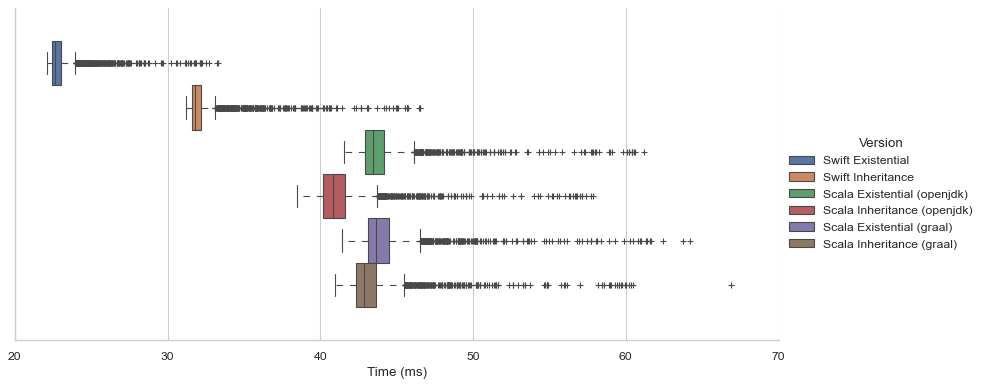

In [11]:
sns.catplot(data=rays, x='Time (ms)', hue='Version', kind="box", height=5, aspect=2)

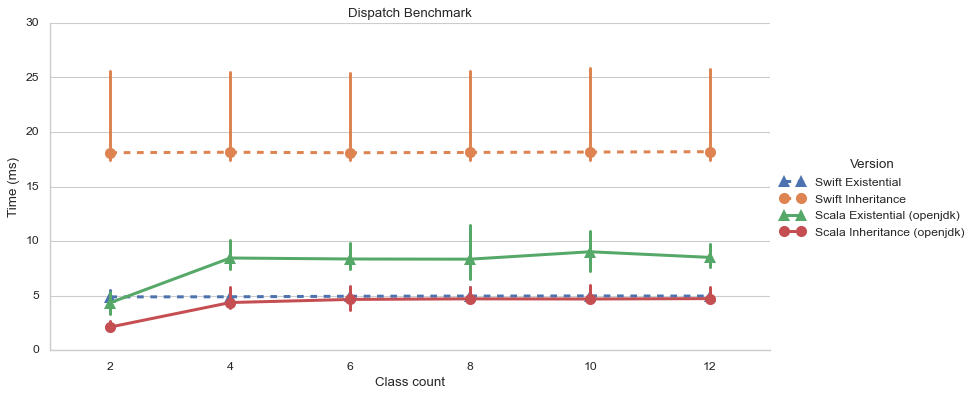

In [12]:
dispatch_filtered = dispatch[(dispatch['Class count'] < 14) & (dispatch['Version'] != "Scala Existential (graal)") & (dispatch['Version'] != "Scala Inheritance (graal)")]
sns.set_theme(style="whitegrid")
sns.catplot(data=dispatch_filtered, x='Class count', y='Time (ms)', hue='Version', kind="point", height=5, aspect=2, errorbar=("pi", 99), markers=["^", "o", "^", "o", "^", "o"], linestyles=["--", "--", "-", "-", "-", "-"],  markeredgewidth=0, markersize=10)
plt.title('Dispatch Benchmark')
plt.savefig('dispatch.svg')
plt.show()

In [13]:
mpl.use("pgf")
font_size = 8
font_color = "#000"
sns.set_theme(context='paper', style='whitegrid', rc={
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    'text.color': font_color,
    'axes.labelcolor': font_color,
    'font.size': font_size,
    'axes.labelsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'text.usetex': True,
    'pgf.rcfonts': False
})

In [14]:
sns.catplot(data=rays, x='Time (ms)', y='Version', kind="violin", height=2, aspect=5.95114/2, orient='h', inner=None, width=1, linewidth=0.5)
plt.savefig('rays_bench.pgf')

In [15]:
dispatch_filtered = dispatch[dispatch['Class count'] < 14]
sns.catplot(data=dispatch_filtered, x='Class count', y='Time (ms)', hue='Version', kind="point", height=2.5, aspect=1.8, errorbar=("pi", 99), markers=["^", "o", "^", "o", "^", "o"], linestyles=["--", "--", "-", "-", "-", "-"],  markeredgewidth=0, markersize=5, linewidth=1)
plt.savefig('dispatch_bench.pgf')

In [16]:
sns.catplot(data=rays, x='Time (ms)', y='Version', kind="box", height=3, aspect=3, orient='h')

In [17]:
sns.catplot(data=dispatch, x='Class count', y='Time (ms)', hue='Version', kind="box", height=5, aspect=2)
plt.title('Dispatch Benchmark')
plt.show()

/var/folders/bh/y39qtjss2_x6bln72knx0qtm0000gn/T/ipykernel_15034/323454525.py:3: UserWarning:

FigureCanvasPgf is non-interactive, and thus cannot be shown



In [18]:
dispatch_filtered = dispatch[dispatch['Class count'] < 14]
sns.catplot(data=dispatch_filtered, x='Class count', y='Time (ms)', hue='Version', kind="violin", height=5, aspect=2, inner=None, linewidth=0)
plt.title('Dispatch Benchmark')
plt.show()

/var/folders/bh/y39qtjss2_x6bln72knx0qtm0000gn/T/ipykernel_15034/910456259.py:4: UserWarning:

FigureCanvasPgf is non-interactive, and thus cannot be shown



In [19]:
sns.set_theme(style="whitegrid")
sns.catplot(data=dispatch_filtered, x='Class count', y='Time (ms)', hue='Version', kind="point", height=5, aspect=2, errorbar=("pi", 99), markers=["^", "o", "^", "o", "^", "o"], linestyles=["--", "--", "-", "-", "-", "-"])
plt.title('Dispatch Benchmark')
plt.show()

/var/folders/bh/y39qtjss2_x6bln72knx0qtm0000gn/T/ipykernel_15034/2604226802.py:4: UserWarning:

FigureCanvasPgf is non-interactive, and thus cannot be shown

